# NBA-Accidents Datamart

# Imports

In [1]:
import pandas as pd
import py_stringmatching.similarity_measure.jaro as jaro
import py_stringmatching

# Reading the cleaned csvs

In [2]:
us_accidents = pd.read_csv("./Cleaned Datasets/us_accidents_cleaned.csv", index_col=[0])
nba = pd.read_csv("./Cleaned Datasets/team_cleaned.csv", index_col=[0])
nba_teams = pd.read_csv("./Cleaned Datasets/nba_elo_cleaned.csv", index_col=[0])

In [3]:
us_accidents

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Start_Lat,Start_Lng
0,3,2016-02-08 05:46:00,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.865147,-84.058723
1,2,2016-02-08 06:07:59,REYNOLDSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.928059,-82.831184
2,2,2016-02-08 06:49:27,WILLIAMSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.063148,-84.032608
3,3,2016-02-08 07:23:34,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.747753,-84.205582
4,2,2016-02-08 07:39:07,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.627781,-84.188354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,2,2019-08-23 18:03:25,RIVERSIDE,CA,False,False,False,False,False,False,False,False,False,False,False,False,34.002480,-117.379360
7728390,2,2019-08-23 19:11:30,SANDIEGO,CA,False,False,False,False,False,False,False,False,False,False,False,False,32.766960,-117.148060
7728391,2,2019-08-23 19:00:21,ORANGE,CA,False,False,False,False,True,False,False,False,False,False,False,False,33.775450,-117.847790
7728392,2,2019-08-23 19:00:21,CULVERCITY,CA,False,False,False,False,False,False,False,False,False,False,False,False,33.992460,-118.403020


# Creation of the data mart

## NBA-Accidents data Mart

This data mart will have all the data necessary to analyze and answer our main question for this project.

To build it, we'll require all the datasets we accquired thus far.

In [4]:
us_state_name_to_abbrev = {
    'ALABAMA': 'AL',
    'ALASKA': 'AK',
    'ARIZONA': 'AZ',
    'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA',
    'COLORADO': 'CO',
    'CONNECTICUT': 'CT',
    'DELAWARE': 'DE',
    'FLORIDA': 'FL',
    'GEORGIA': 'GA',
    'HAWAII': 'HI',
    'IDAHO': 'ID',
    'ILLINOIS': 'IL',
    'INDIANA': 'IN',
    'IOWA': 'IA',
    'KANSAS': 'KS',
    'KENTUCKY': 'KY',
    'LOUISIANA': 'LA',
    'MAINE': 'ME',
    'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI',
    'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO',
    'MONTANA': 'MT',
    'NEBRASKA': 'NE',
    'NEVADA': 'NV',
    'NEWHAMPSHIRE': 'NH',
    'NEWJERSEY': 'NJ',
    'NEWMEXICO': 'NM',
    'NEWYORK': 'NY',
    'NORTHCAROLINA': 'NC',
    'NORTHDAKOTA': 'ND',
    'OHIO': 'OH',
    'OKLAHOMA': 'OK',
    'OREGON': 'OR',
    'PENNSYLVANIA': 'PA',
    'RHODEISLAND': 'RI',
    'SOUTHCAROLINA': 'SC',
    'SOUTHDAKOTA': 'SD',
    'TENNESSEE': 'TN',
    'TEXAS': 'TX',
    'UTAH': 'UT',
    'VERMONT': 'VT',
    'VIRGINIA': 'VA',
    'WASHINGTON': 'WA',
    'WESTVIRGINIA': 'WV',
    'WISCONSIN': 'WI',
    'WYOMING': 'WY',
    'DISTRICTOFCOLUMBIA': 'DC'
}


In [5]:
nba_teams["state"] = nba_teams["state"].apply(lambda x: us_state_name_to_abbrev[x].upper())

In [6]:
for index in nba.index:
    score1 = nba.loc[index, "score1"]
    score2 = nba.loc[index, "score2"]
    if score1 > score2:
        nba.loc[index, "loser"] = nba.loc[index, "team2"]
        nba.loc[index, "winner"] = nba.loc[index, "team1"]
    if score2 > score1:
        nba.loc[index, "loser"] = nba.loc[index, "team1"]
        nba.loc[index, "winner"] = nba.loc[index, "team2"]
        
nba = nba.dropna(subset=['loser'])
del nba_teams["id"]

### Matching team information to NBA match loser team

In [7]:
nba_teams

,full_name,abbreviation,nickname,city,state,year_founded
0,ATLANTAHAWKS,ATL,HAWKS,ATLANTA,AK,1949.0
1,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
2,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
3,NEWORLEANSPELICANS,NOP,PELICANS,NEWORLEANS,LA,2002.0
4,CHICAGOBULLS,CHI,BULLS,CHICAGO,IL,1966.0
5,DALLASMAVERICKS,DAL,MAVERICKS,DALLAS,TX,1980.0
6,DENVERNUGGETS,DEN,NUGGETS,DENVER,CO,1976.0
7,GOLDENSTATEWARRIORS,GSW,WARRIORS,GOLDENSTATE,CA,1946.0
8,HOUSTONROCKETS,HOU,ROCKETS,HOUSTON,TX,1967.0
9,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0


In [8]:
nba['matches'] = [[] for _ in range(len(nba))] 

for idx in nba.index:
    for abbr in nba_teams.abbreviation.values:
        abbr_score = jaro.Jaro().get_sim_score(nba.loc[idx, "loser"], abbr)

        if abbr_score >= 0.8:
            nba.loc[idx, "matches"].append(abbr)
nba

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,carmelo2_pre,carmelo1_post,carmelo2_post,carmelo_prob1,carmelo_prob2,score1,score2,loser,winner,matches
0,0,1946-11-01,1947,0,False,TRH,NYK,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,66.0,68.0,TRH,NYK,[]
1,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,NaN,NaN,NaN,NaN,NaN,63.0,47.0,NYK,CHS,[NYK]
2,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,59.0,53.0,BOS,PRO,[BOS]
3,3,1946-11-02,1947,0,False,STB,PIT,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,56.0,51.0,PIT,STB,[]
4,4,1946-11-02,1947,0,False,DTF,WSC,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,33.0,50.0,DTF,WSC,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67007,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,1518.775821,1670.684530,1507.976699,0.746325,0.253675,130.0,95.0,MIL,PHI,[MIL]
67008,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,1353.366271,1551.305868,1380.535101,0.865447,0.134553,98.0,110.0,CLE,NYK,[CLE]
67009,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,1776.681162,1355.612647,1748.389768,0.138616,0.861384,96.0,83.0,HOU,SAC,[HOU]
67010,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,1685.253159,1618.401111,1677.637894,0.589215,0.410785,102.0,93.0,UTA,POR,[UTA]


1st Data fusion strategy: If more than two teams match with the same abbreviation, we keep the most recently founded team's info. This is due to the fact that there are some old teams whose match data won't match to any of the US accidents data.

In [9]:
match_conflicts = nba[nba['matches'].apply(lambda x: len(x) > 1)]

for idx in match_conflicts.index:
    most_recent = None
    for match in match_conflicts.loc[idx, "matches"]:
        year = nba_teams[nba_teams["abbreviation"] == match].year

        if year > most_recent:
            most_recent = match
    nba.loc[idx, "matches"] = [most_recent]

Keeping only rows where there were matches:

In [10]:
nba = nba[nba['matches'].apply(lambda x: len(x) > 0)]

Removing the match from the list:

In [11]:
nba['matches'] = nba['matches'].apply(lambda x: x[0])
nba

/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_59998/889968744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba['matches'] = nba['matches'].apply(lambda x: x[0])


,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,carmelo2_pre,carmelo1_post,carmelo2_post,carmelo_prob1,carmelo_prob2,score1,score2,loser,winner,matches
1,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,NaN,NaN,NaN,NaN,NaN,63.0,47.0,NYK,CHS,NYK
2,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,59.0,53.0,BOS,PRO,BOS
7,7,1946-11-05,1947,0,False,BOS,CHS,1294.845800,1309.652100,0.620204,...,NaN,NaN,NaN,NaN,NaN,55.0,57.0,BOS,CHS,BOS
16,16,1946-11-09,1947,0,False,DTF,BOS,1268.446800,1288.413900,0.613182,...,NaN,NaN,NaN,NaN,NaN,69.0,46.0,BOS,DTF,BOS
18,18,1946-11-11,1947,0,False,NYK,CHS,1307.319700,1315.252200,0.629479,...,NaN,NaN,NaN,NaN,NaN,68.0,78.0,NYK,CHS,NYK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67007,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,1518.775821,1670.684530,1507.976699,0.746325,0.253675,130.0,95.0,MIL,PHI,MIL
67008,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,1353.366271,1551.305868,1380.535101,0.865447,0.134553,98.0,110.0,CLE,NYK,CLE
67009,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,1776.681162,1355.612647,1748.389768,0.138616,0.861384,96.0,83.0,HOU,SAC,HOU
67010,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,1685.253159,1618.401111,1677.637894,0.589215,0.410785,102.0,93.0,UTA,POR,UTA


Merging on the matched abbreviations we get a dataset that contains nba matches and the loser's information, which includes that state. As that is what matters for our analysis.

In [12]:
merged_nba = pd.merge(nba, nba_teams.add_prefix("loser_"), left_on="matches", right_on="loser_abbreviation", how="inner")

In [13]:
del merged_nba["matches"]

In [14]:
merged_nba

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,score1,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded
0,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,63.0,47.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0
1,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,59.0,53.0,BOS,PRO,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
2,7,1946-11-05,1947,0,False,BOS,CHS,1294.845800,1309.652100,0.620204,...,55.0,57.0,BOS,CHS,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
3,16,1946-11-09,1947,0,False,DTF,BOS,1268.446800,1288.413900,0.613182,...,69.0,46.0,BOS,DTF,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
4,18,1946-11-11,1947,0,False,NYK,CHS,1307.319700,1315.252200,0.629479,...,68.0,78.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46632,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,130.0,95.0,MIL,PHI,MILWAUKEEBUCKS,MIL,BUCKS,MILWAUKEE,WI,1968.0
46633,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,98.0,110.0,CLE,NYK,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
46634,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,96.0,83.0,HOU,SAC,HOUSTONROCKETS,HOU,ROCKETS,HOUSTON,TX,1967.0
46635,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,102.0,93.0,UTA,POR,UTAHJAZZ,UTA,JAZZ,UTAH,UT,1974.0


### Matching US Accidents data to NBA loser teams' losses

In [15]:
merged_nba.columns

Index(['index', 'date', 'season', 'neutral', 'playoff', 'team1', 'team2',
       'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post',
       'elo2_post', 'carmelo1_pre', 'carmelo2_pre', 'carmelo1_post',
       'carmelo2_post', 'carmelo_prob1', 'carmelo_prob2', 'score1', 'score2',
       'loser', 'winner', 'loser_full_name', 'loser_abbreviation',
       'loser_nickname', 'loser_city', 'loser_state', 'loser_year_founded'],
      dtype='object')

In [16]:
us_accidents.columns

Index(['Severity', 'Start_Time', 'City', 'State', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Start_Lat',
       'Start_Lng'],
      dtype='object')

In [17]:
merged_nba["blocking"] = merged_nba.apply(lambda row: row["date"] + row["loser_state"], axis=1)
merged_nba

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,blocking
0,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,47.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0,1946-11-02NY
1,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,53.0,BOS,PRO,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0,1946-11-02MA
2,7,1946-11-05,1947,0,False,BOS,CHS,1294.845800,1309.652100,0.620204,...,57.0,BOS,CHS,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0,1946-11-05MA
3,16,1946-11-09,1947,0,False,DTF,BOS,1268.446800,1288.413900,0.613182,...,46.0,BOS,DTF,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0,1946-11-09MA
4,18,1946-11-11,1947,0,False,NYK,CHS,1307.319700,1315.252200,0.629479,...,78.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0,1946-11-11NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46632,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,95.0,MIL,PHI,MILWAUKEEBUCKS,MIL,BUCKS,MILWAUKEE,WI,1968.0,2018-04-11WI
46633,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,110.0,CLE,NYK,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,2018-04-11OH
46634,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,83.0,HOU,SAC,HOUSTONROCKETS,HOU,ROCKETS,HOUSTON,TX,1967.0,2018-04-11TX
46635,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,93.0,UTA,POR,UTAHJAZZ,UTA,JAZZ,UTAH,UT,1974.0,2018-04-11UT


In [18]:
us_accidents["blocking"] = us_accidents.apply(lambda row: row["Start_Time"].split(" ")[0] + row["State"], axis=1)
us_accidents 

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Start_Lat,Start_Lng,blocking
0,3,2016-02-08 05:46:00,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.865147,-84.058723,2016-02-08OH
1,2,2016-02-08 06:07:59,REYNOLDSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.928059,-82.831184,2016-02-08OH
2,2,2016-02-08 06:49:27,WILLIAMSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.063148,-84.032608,2016-02-08OH
3,3,2016-02-08 07:23:34,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.747753,-84.205582,2016-02-08OH
4,2,2016-02-08 07:39:07,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.627781,-84.188354,2016-02-08OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,2,2019-08-23 18:03:25,RIVERSIDE,CA,False,False,False,False,False,False,False,False,False,False,False,False,34.002480,-117.379360,2019-08-23CA
7728390,2,2019-08-23 19:11:30,SANDIEGO,CA,False,False,False,False,False,False,False,False,False,False,False,False,32.766960,-117.148060,2019-08-23CA
7728391,2,2019-08-23 19:00:21,ORANGE,CA,False,False,False,False,True,False,False,False,False,False,False,False,33.775450,-117.847790,2019-08-23CA
7728392,2,2019-08-23 19:00:21,CULVERCITY,CA,False,False,False,False,False,False,False,False,False,False,False,False,33.992460,-118.403020,2019-08-23CA


In [19]:
blocking_matches = us_accidents.merge(merged_nba, on='blocking')
blocking_matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score1,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded
0,2,2016-02-22 05:20:31,DAYTON,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
1,2,2016-02-22 06:11:53,BOWLINGGREEN,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
2,2,2016-02-22 06:54:32,REYNOLDSBURG,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
3,2,2016-02-22 07:09:58,COLUMBUS,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
4,2,2016-02-22 07:14:44,CANALWINCHESTER,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349835,2,2017-10-30 19:44:00,SALINAS,CA,False,False,False,True,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0
349838,2,2017-10-30 21:24:07,LOSANGELES,CA,False,False,False,False,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0


In [20]:
leven = py_stringmatching.Levenshtein()
jaro = py_stringmatching.Jaro()

def similarity_accident_game(acc_city, acc_state, nba_city, nba_state):
    state_score = jaro.get_sim_score(nba_state, acc_state)
    city_score = leven.get_sim_score(nba_city, acc_city)
    score = state_score * 0.5 + city_score * 0.5
    return score

In [21]:
blocking_matches['similarity'] = blocking_matches.apply(
    lambda row: similarity_accident_game(row["City"], row["State"], row["loser_city"], row["loser_state"]), axis=1
)
blocking_matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,similarity
0,2,2016-02-22 05:20:31,DAYTON,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.555556
1,2,2016-02-22 06:11:53,BOWLINGGREEN,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.541667
2,2,2016-02-22 06:54:32,REYNOLDSBURG,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.541667
3,2,2016-02-22 07:09:58,COLUMBUS,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.555556
4,2,2016-02-22 07:14:44,CANALWINCHESTER,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349835,2,2017-10-30 19:44:00,SALINAS,CA,False,False,False,True,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,0.650000
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.000000
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.000000
349838,2,2017-10-30 21:24:07,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.000000


In [22]:
matches = blocking_matches[blocking_matches['similarity'] >= 0.75].copy()
matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,similarity
40,3,2016-03-07 07:27:39,CLEVELAND,OH,False,False,False,False,False,False,...,106.0,CLE,MEM,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,1.00
348,2,2016-12-02 02:51:52,LOSALTOS,CA,False,False,False,False,False,False,...,80.0,LAL,TOR,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,0.75
384,2,2016-12-02 09:14:27,LOSGATOS,CA,False,False,False,True,False,False,...,80.0,LAL,TOR,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,0.75
409,2,2016-12-02 09:53:29,SACRAMENTO,CA,False,False,False,False,False,False,...,92.0,SAC,BOS,SACRAMENTOKINGS,SAC,KINGS,SACRAMENTO,CA,1948.0,1.00
451,2,2016-12-02 12:11:01,SACRAMENTO,CA,False,False,True,False,False,False,...,92.0,SAC,BOS,SACRAMENTOKINGS,SAC,KINGS,SACRAMENTO,CA,1948.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349821,2,2017-10-30 16:56:01,ORANGE,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,0.75
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00
349838,2,2017-10-30 21:24:07,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00


Data Fusion Problem: There are a couple of rows that represent the same accident but get linked with multiple teams from the exact same state. \
This happens because there a re multiple NBA games on certain days and these end up countain more than once, which needs to be dealth with.

In [23]:
matches["Start_Time"].value_counts()

Start_Time
2017-02-02 08:46:53    12
2017-02-02 19:06:31    10
2016-12-23 14:52:57     8
2017-12-06 06:04:10     8
2016-11-23 07:50:52     6
                       ..
2017-02-27 18:04:52     1
2017-02-27 18:05:17     1
2017-02-27 18:25:10     1
2017-02-27 18:24:50     1
2017-10-30 21:24:07     1
Name: count, Length: 40042, dtype: int64

In [24]:
conflicts = matches["Start_Time"].value_counts()
conflicts = conflicts[conflicts >= 2]

All of them are from the same exact state, therefore they all reference the same accident.

In [25]:
for date in conflicts.index:
    not_conflicts = matches[matches["Start_Time"] == date].State.unique()

    if len(not_conflicts) > 2:
        print(date)

2nd Data Fusion Strategy: Since most of these refer to the same exact accident, we'll keep only one row to avoid including duplicates of the same accident. We'll do this because we want to avoid inflating the number of accidents.

In [26]:
for date in conflicts.index:
    for row in matches[matches["Start_Time"] == date].index[1:]:
        matches = matches.drop(row)

In [27]:
matches["Start_Time"].value_counts()

Start_Time
2016-03-07 07:27:39    1
2017-12-13 15:13:32    1
2017-12-13 09:25:19    1
2017-12-13 09:38:33    1
2017-12-13 09:42:43    1
                      ..
2017-02-13 19:53:58    1
2017-02-13 20:08:28    1
2017-02-13 20:35:31    1
2017-02-13 20:54:47    1
2017-10-30 21:24:07    1
Name: count, Length: 40042, dtype: int64

In [28]:
matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,similarity
40,3,2016-03-07 07:27:39,CLEVELAND,OH,False,False,False,False,False,False,...,106.0,CLE,MEM,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,1.00
348,2,2016-12-02 02:51:52,LOSALTOS,CA,False,False,False,False,False,False,...,80.0,LAL,TOR,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,0.75
384,2,2016-12-02 09:14:27,LOSGATOS,CA,False,False,False,True,False,False,...,80.0,LAL,TOR,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,0.75
409,2,2016-12-02 09:53:29,SACRAMENTO,CA,False,False,False,False,False,False,...,92.0,SAC,BOS,SACRAMENTOKINGS,SAC,KINGS,SACRAMENTO,CA,1948.0,1.00
451,2,2016-12-02 12:11:01,SACRAMENTO,CA,False,False,True,False,False,False,...,92.0,SAC,BOS,SACRAMENTOKINGS,SAC,KINGS,SACRAMENTO,CA,1948.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349791,2,2017-10-30 09:14:01,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00
349821,2,2017-10-30 16:56:01,ORANGE,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,0.75
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00


# Analysis of the data

In [29]:
accidents_nba = matches.copy()

In [30]:
accidents_nba["date"] = accidents_nba["date"].apply(lambda x: x.split(" ")[0])
us_accidents["Start_Time"] = us_accidents["Start_Time"].apply(lambda x: x.split(" ")[0])

In [31]:
us_accidents['Start_Time'] = pd.to_datetime(us_accidents['Start_Time'])
accidents_nba['date'] = pd.to_datetime(accidents_nba['date'])

In [32]:
game_dates = accidents_nba["date"].dt.year.unique()

In [33]:
us_accidents_no_game = us_accidents[~us_accidents['Start_Time'].isin(game_dates)]

In [34]:
accidents_nba.date.values
list(map(lambda x: str(x).split("-")[0], accidents_nba.date.values))
pd.Series(list(map(lambda x: str(x).split("-")[0], accidents_nba.date.values))).unique()

array(['2016', '2017', '2018'], dtype=object)

In [35]:
us_accidents_no_game = us_accidents_no_game[us_accidents_no_game["Start_Time"].dt.year.isin([2016, 2017, 2018])]

In [36]:
accidents_nba_playoffs = accidents_nba.query("playoff == True")

### Exploratory Data Analysis

Taking a look at the amount of accidents in each of the following categories we get:

In [37]:
print("Number of accidents in no NBA game days: {0}".format(us_accidents_no_game.shape[0]))
print("Number of accidents in NBA game days: {0}".format(accidents_nba.shape[0]))
print("Number of accidents in NBA game days: {0}".format(accidents_nba_playoffs.shape[0]))

Number of accidents in no NBA game days: 2012663
Number of accidents in NBA game days: 40042
Number of accidents in NBA game days: 1475


Grouping them by state and date.

In [38]:
accidents_by_day = accidents_nba.groupby(['date', 'State']).size().reset_index(name='accident_count')
accidents_by_day

,date,State,accident_count
0,2016-02-22,OH,3
1,2016-03-07,OH,1
2,2016-03-14,OH,4
3,2016-03-23,CA,105
4,2016-03-23,PA,6
...,...,...,...
1638,2018-04-11,IL,15
1639,2018-04-11,OH,10
1640,2018-04-11,TN,13
1641,2018-04-11,TX,199


In [39]:
accidents_by_day.State.unique()

array(['OH', 'CA', 'PA', 'NY', 'MA', 'FL', 'LA', 'MI', 'MN', 'TX', 'WI',
       'OR', 'CO', 'TN', 'IL', 'IN', 'OK'], dtype=object)

In [40]:
accidents_by_day_playoffs = accidents_nba_playoffs.groupby(['date', 'State']).size().reset_index(name='accident_count')
accidents_by_day_playoffs

,date,State,accident_count
0,2016-04-21,CA,5
1,2016-04-23,CA,1
2,2016-04-25,CA,69
3,2016-04-27,CA,44
4,2016-04-29,CA,75
5,2016-05-16,CA,1
6,2016-05-23,OH,4
7,2016-05-24,CA,5
8,2016-06-02,OH,6
9,2016-06-08,CA,5


In [41]:
accidents_by_no_game_day = us_accidents_no_game.groupby(['Start_Time', 'State']).size().reset_index(name='accident_count')
accidents_by_no_game_day

,Start_Time,State,accident_count
0,2016-01-14,PA,1
1,2016-02-08,IN,1
2,2016-02-08,KY,1
3,2016-02-08,OH,58
4,2016-02-09,IN,10
...,...,...,...
37613,2018-12-31,TX,260
37614,2018-12-31,UT,55
37615,2018-12-31,VA,105
37616,2018-12-31,WA,38


In [42]:
accidents_by_no_game_day = accidents_by_no_game_day[accidents_by_no_game_day["State"].isin(accidents_by_day.State.unique())]
accidents_by_no_game_day

,Start_Time,State,accident_count
0,2016-01-14,PA,1
1,2016-02-08,IN,1
3,2016-02-08,OH,58
4,2016-02-09,IN,10
5,2016-02-09,MI,2
...,...,...,...
37607,2018-12-31,OR,133
37608,2018-12-31,PA,70
37612,2018-12-31,TN,41
37613,2018-12-31,TX,260


In [43]:
accidents_by_no_game_day = accidents_by_no_game_day[~accidents_by_no_game_day["Start_Time"].dt.month.isin([7, 8, 9])]
accidents_by_no_game_day

,Start_Time,State,accident_count
0,2016-01-14,PA,1
1,2016-02-08,IN,1
3,2016-02-08,OH,58
4,2016-02-09,IN,10
5,2016-02-09,MI,2
...,...,...,...
37607,2018-12-31,OR,133
37608,2018-12-31,PA,70
37612,2018-12-31,TN,41
37613,2018-12-31,TX,260


In [44]:
avg_accidents_per_no_game_day = accidents_by_no_game_day.accident_count.sum() / accidents_by_no_game_day.shape[0]
avg_accidents_per_game_day = accidents_by_day.accident_count.sum() / accidents_by_day.shape[0]
avg_accidents_per_playoff_day= accidents_by_day_playoffs.accident_count.sum() / accidents_by_day_playoffs.shape[0]

Taking a look at the mean number of accidents in each category we get the following results.

In [45]:
print("Average accidents on non NBA game days: {0:.3f}".format(avg_accidents_per_no_game_day))
print("Average accidents on NBA game loss days: {0:.3f}".format(avg_accidents_per_game_day))
print("Average accidents on NBA playoff game loss days: {0:.3f}".format(avg_accidents_per_playoff_day))

Average accidents on non NBA game days: 90.207
Average accidents on NBA game loss days: 24.371
Average accidents on NBA playoff game loss days: 25.877


The shher difference size between these makes the comparisons not very fair.

In [46]:
accidents_by_day

,date,State,accident_count
0,2016-02-22,OH,3
1,2016-03-07,OH,1
2,2016-03-14,OH,4
3,2016-03-23,CA,105
4,2016-03-23,PA,6
...,...,...,...
1638,2018-04-11,IL,15
1639,2018-04-11,OH,10
1640,2018-04-11,TN,13
1641,2018-04-11,TX,199


In [47]:
accidents_by_day.describe()

,date,accident_count
count,1643,1643.000000
mean,2017-07-07 01:15:22.458916864,24.371272
min,2016-02-22 00:00:00,1.000000
25%,2017-01-12 12:00:00,4.000000
50%,2017-05-02 00:00:00,10.000000
75%,2018-01-10 00:00:00,30.000000
max,2018-04-11 00:00:00,348.000000
std,NaN,38.615169


In [48]:
accidents_by_no_game_day.describe()

,Start_Time,accident_count
count,11213,11213.000000
mean,2017-09-21 09:03:36.712744192,90.206903
min,2016-01-14 00:00:00,1.000000
25%,2017-02-06 00:00:00,11.000000
50%,2017-11-03 00:00:00,44.000000
75%,2018-04-18 00:00:00,102.000000
max,2018-12-31 00:00:00,940.000000
std,NaN,130.236318


## Creating some visualizations for the data

Next up we'll try to take a look at some visualizations of the data when it comes to accidents in NBA game days and non-game days.

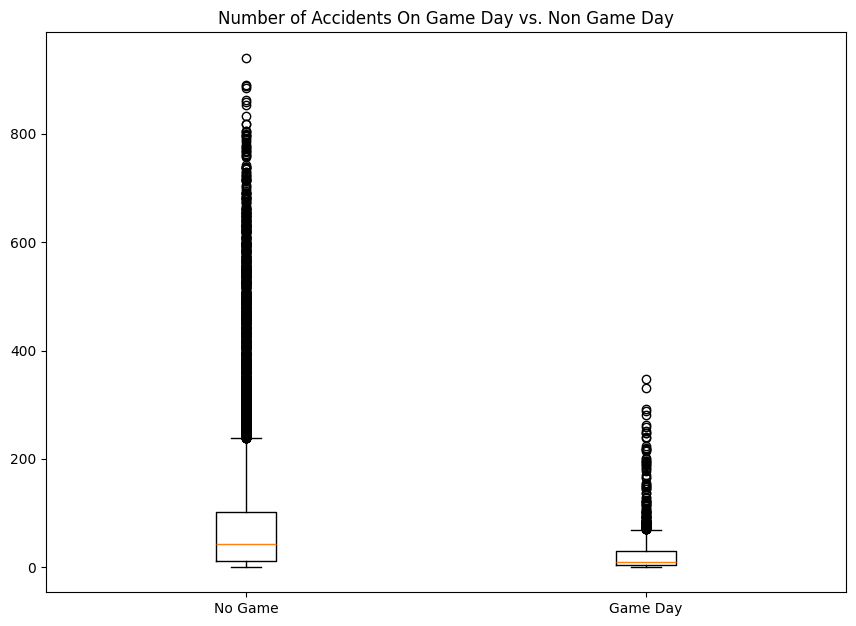

In [49]:
import matplotlib.pyplot as plt

d_1 = accidents_by_no_game_day.accident_count.values
d_2 = accidents_by_day.accident_count.values

d = [d_1, d_2]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
bp = ax.boxplot(d)

plt.title("Number of Accidents On Game Day vs. Non Game Day")
plt.xticks(ticks=[1, 2], labels=["No Game", "Game Day"])
plt.show()

In [50]:
state_count = accidents_by_day[["State", "accident_count"]].groupby("State").size()

<Axes: xlabel='State'>

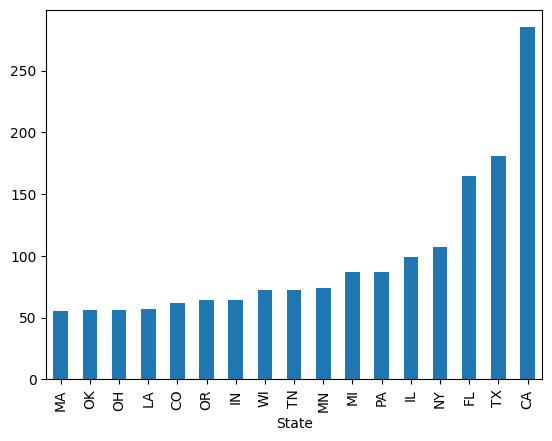

In [51]:
state_count.sort_values().plot.bar()

<Axes: xlabel='State'>

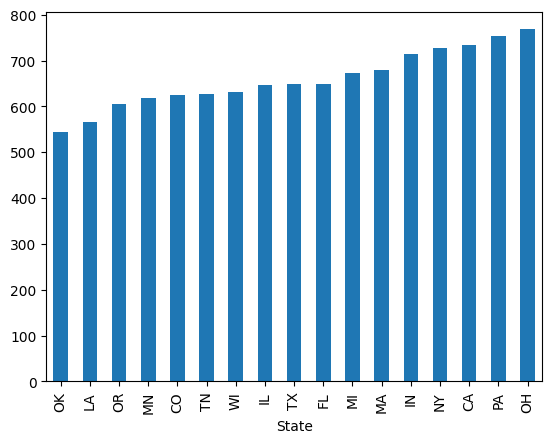

In [52]:
accidents_by_no_game_day[["State", "accident_count"]].groupby("State").size().sort_values().plot.bar()

In [53]:
accidents_by_day["month"] = accidents_by_day.date.dt.month
accidents_by_day["year"] = accidents_by_day.date.dt.year

accidents_by_no_game_day["month"] = accidents_by_no_game_day["Start_Time"].dt.month
accidents_by_no_game_day["year"] = accidents_by_no_game_day["Start_Time"].dt.year

/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_59998/753090322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_by_no_game_day["month"] = accidents_by_no_game_day["Start_Time"].dt.month
/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_59998/753090322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_by_no_game_day["year"] = accidents_by_no_game_day["Start_Time"].dt.year


### Taking a look at time series

Grouping the accidents by Month and Year to analyze temporal trends we get:s

In [54]:
teste = accidents_by_day[["State", "accident_count", "month", "year"]].groupby(["month", "year"]).size()
teste2 = accidents_by_no_game_day[["State", "accident_count", "month", "year"]].groupby(["month", "year"]).size()

Some observations:
* Months 7, 8, 9 don't have official NBA games.
* Months 6, 10 don't have a lot of games.

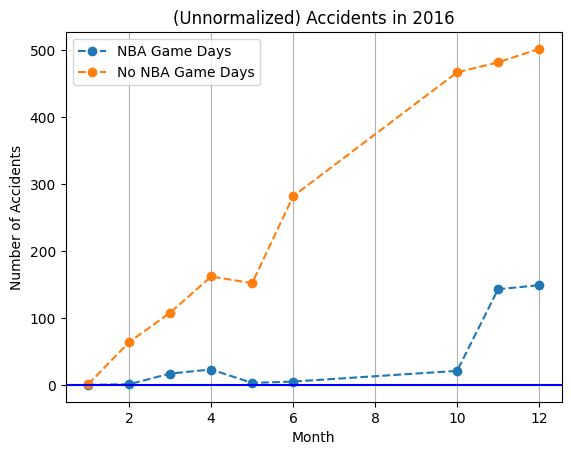

In [55]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2016_nba = [teste[i][2016] if i in teste and 2016 in teste[i] else 0 for i in months]
values_2016_no_nba = [ teste2[i, 2016] if i in teste2 and 2016 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2016_nba, '--o')
plt.plot(months, values_2016_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("(Unnormalized) Accidents in 2016")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

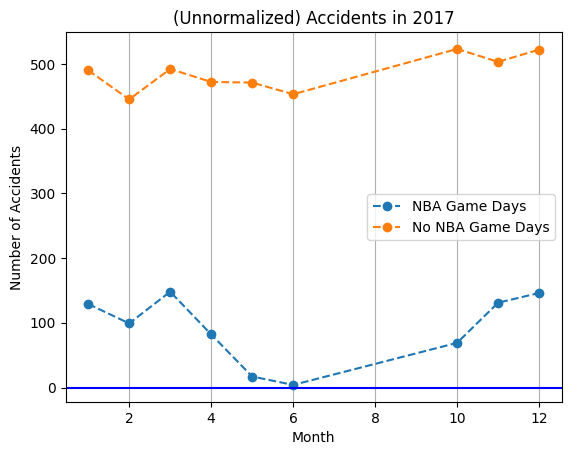

In [56]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2017_nba = [teste[i][2017] if i in teste and 2017 in teste[i] else 0 for i in months]
values_2017_no_nba = [ teste2[i, 2017] if i in teste2 and 2017 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2017_nba, '--o')
plt.plot(months, values_2017_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("(Unnormalized) Accidents in 2017")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

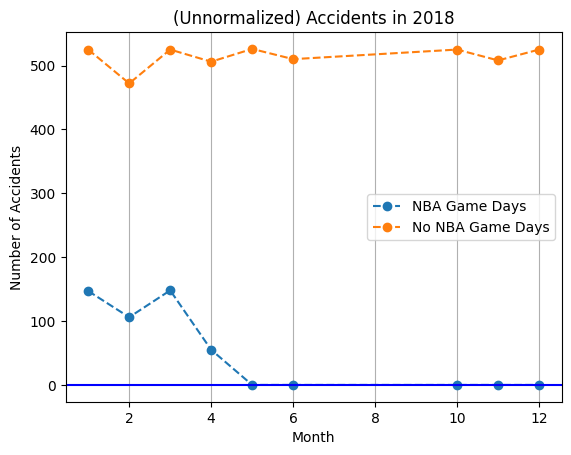

In [57]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2018_nba = [teste[i][2018] if i in teste and 2018 in teste[i] else 0 for i in months]
values_2018_no_nba = [ teste2[i, 2018] if i in teste2 and 2018 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2018_nba, '--o')
plt.plot(months, values_2018_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("(Unnormalized) Accidents in 2018")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

It makes no sense to compare Non-Game days with Game days since there are WAY more Non-Game days.

To compare them, we'll normalize the values per month in each of the years. \
That is, we'll divide the number of accidents in a month by the total number of accidents in a given year. This effectively makes it so we're comparing proportions and not raw numbers.

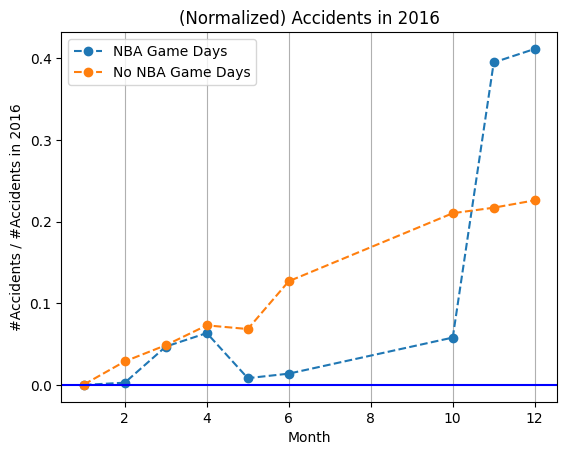

In [58]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2016_nba = [teste[i][2016] / teste.xs(2016, level='year').sum() if i in teste and 2016 in teste[i] else 0 for i in months]
values_2016_no_nba = [ teste2[i, 2016] / teste2.xs(2016, level='year').sum() if i in teste2 and 2016 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2016_nba, '--o')
plt.plot(months, values_2016_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("#Accidents / #Accidents in 2016")
plt.title("(Normalized) Accidents in 2016")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

In 2016 we can conclude that:
* The proportion of accidents in Non-Game days was bigger in all months except in November and December.

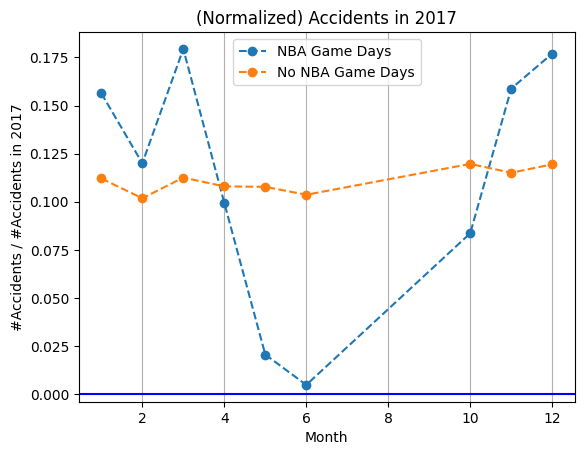

In [59]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2017_nba = [teste[i][2017] / teste.xs(2017, level='year').sum() if i in teste and 2017 in teste[i] else 0 for i in months]
values_2017_no_nba = [ teste2[i, 2017] / teste2.xs(2017, level='year').sum() if i in teste2 and 2017 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2017_nba, '--o')
plt.plot(months, values_2017_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("#Accidents / #Accidents in 2017")
plt.title("(Normalized) Accidents in 2017")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

In 2017 we can conlude that:
* In Janurary, February, March, November and December the proportion of accidents in game days was bigger than in Non-Game days;
* In the other months the proportions of accidents in Non-Game days were bigger;

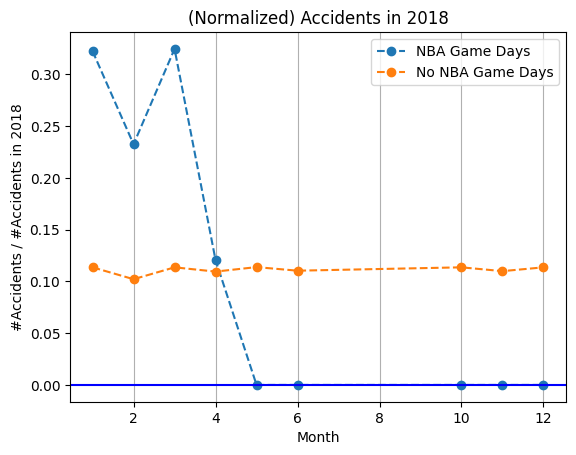

In [60]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2018_nba = [teste[i][2018] / teste.xs(2018, level='year').sum() if i in teste and 2018 in teste[i] else 0 for i in months]
values_2018_no_nba = [ teste2[i, 2018] / teste2.xs(2018, level='year').sum() if i in teste2 and 2018 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2018_nba, '--o')
plt.plot(months, values_2018_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("#Accidents / #Accidents in 2018")
plt.title("(Normalized) Accidents in 2018")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

In 2018 we can conclude that:
* Up to when we have data, the proporions were always bigger in game days;

### Taking a look at proportions per state

In [61]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


Creating a dataframe that contains the accidents in game days including the month and year.

In [62]:
accidents_by_day

,date,State,accident_count,month,year
0,2016-02-22,OH,3,2,2016
1,2016-03-07,OH,1,3,2016
2,2016-03-14,OH,4,3,2016
3,2016-03-23,CA,105,3,2016
4,2016-03-23,PA,6,3,2016
...,...,...,...,...,...
1638,2018-04-11,IL,15,4,2018
1639,2018-04-11,OH,10,4,2018
1640,2018-04-11,TN,13,4,2018
1641,2018-04-11,TX,199,4,2018


Grouping this dataframe by State and Year, we can get the number of accidents in a state for 2016, 2017 and 2018 grouped by month.

In [63]:
teste_mapa = accidents_by_day.groupby(["State", "year"]).size().xs(2017, level="year")
teste_mapa2 = accidents_by_no_game_day.groupby(["State", "year"]).size().xs(2017, level="year")

diff = teste_mapa2.apply(lambda x: x / teste_mapa2.sum()) - teste_mapa.apply(lambda x: x / teste_mapa.sum())
diff.values

array([-0.10602774,  0.0219072 , -0.03814896,  0.00185104,  0.01735571,
        0.01220607,  0.02417088,  0.01518438,  0.01143154,  0.00306316,
        0.03169651,  0.01099395,  0.01589068,  0.00647075,  0.01342235,
       -0.05633078,  0.01486325])

In [64]:
df = pd.DataFrame({
    "State": diff.index,
    "accident_diff": diff.values
})

In [65]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations='State',
    locationmode='USA-states',
    color='accident_diff',
    color_continuous_scale='RdBu',
    scope='usa',
    title='Relative Difference in Accident Proportions in 2017'
)

fig.show()


In 2017 we can conclude that:
* In California the proportion of accidents on game days was bigger by a factor of 0.1;
* In Texas the proportion of accidents on game days was bigger by a factor of 0.05;
* In Florida the proportion of accidents on game days was bigger by a factor of 0.03;
* The rest had more accidents in Non-Game days;

In [66]:
teste_mapa = accidents_by_day.groupby(["State", "year"]).size().xs(2016, level="year")
teste_mapa2 = accidents_by_no_game_day.groupby(["State", "year"]).size().xs(2016, level="year")

diff = teste_mapa2.apply(lambda x: x / teste_mapa2.sum()) - teste_mapa.apply(lambda x: x / teste_mapa.sum())
diff.values

array([-0.12571052,  0.00598029, -0.04476382, -0.00146583,  0.04279777,
        0.00604002,  0.02877408,  0.00195859,  0.0003957 ,  0.01844607,
        0.05715246,  0.00345677, -0.002307  ,  0.01127122,  0.03174307,
       -0.03923896,  0.00547011])

In [67]:
df = pd.DataFrame({
    "State": diff.index,
    "accident_diff": diff.values
})

In [68]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations='State',
    locationmode='USA-states',
    color='accident_diff',
    color_continuous_scale='RdBu',
    scope='usa',
    title='Relative Difference in Accident Proportions in 2016'
)

fig.show()

In 2016 we can conclude that:
* In California the proportion of accidents on game days was bigger by a factor of 0.12;
* In Texas the proportion of accidents on game days was bigger by a factor of 0.04;
* In Florida the proportion of accidents on game days was bigger by a factor of 0.04;
* In Oregon the proportion of accidents on game days was bigger by a factor of 0.002;
* In Illinois the proportion of accidents on game days was bigger by a factor of 0.001;
* The rest had more accidents in Non-Game days, however the difference in some of these states is not very big;

In [69]:
teste_mapa = accidents_by_day.groupby(["State", "year"]).size().xs(2018, level="year")
teste_mapa2 = accidents_by_no_game_day.groupby(["State", "year"]).size().xs(2018, level="year")

diff = teste_mapa2.apply(lambda x: x / teste_mapa2.sum()) - teste_mapa.apply(lambda x: x / teste_mapa.sum())
diff.values

df = pd.DataFrame({
    "State": diff.index,
    "accident_diff": diff.values
})

fig = px.choropleth(
    df,
    locations='State',
    locationmode='USA-states',
    color='accident_diff',
    color_continuous_scale='RdBu',
    scope='usa',
    title='Relative Difference in Accident Proportions in 2018'
)

fig.show()

In 2018 we can conclude that:
* In California the proportion of accidents on game days was bigger by a factor of 0.09;
* In Texas the proportion of accidents on game days was bigger by a factor of 0.05;
* In Florida the proportion of accidents on game days was bigger by a factor of 0.04;
* In Tennessee the proportion of accidents on game days was bigger by a factor of 0.006;
* In Illinois the proportion of accidents on game days was bigger by a factor of 0.001;
* In New York the proportion of accidents on game days was bigger by a factor of 0.001;
* In Michigan the proportion of accidents on game days was bigger by a factor of 0.002;
* The rest had more accidents in Non-Game days, however the difference in some of these states is not very big;